In [7]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [8]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [9]:
chembl_df = pd.read_csv(
    HERE / "/home/jovyan/project/a3_ligands_chembl_smiles.txt",
    index_col=0,
)

print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()

Shape of dataframe :  (3244, 2)


,smiles,pchembl
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150000
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470000
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385000
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,7.960000
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,6.163333


In [10]:
chembl_df = chembl_df[["smiles", "pchembl"]]
chembl_df.head()

,smiles,pchembl
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150000
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470000
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385000
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,7.960000
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,6.163333


In [12]:
chembl_df["active"] = np.zeros(len(chembl_df))

chembl_df.loc[chembl_df[chembl_df.pchembl >= 6.3].index, "active"] = 1.0

print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 2259
Number of inactive compounds: 985


In [13]:
chembl_df.head()

,smiles,pchembl,active
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150000,1.0
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470000,1.0
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385000,1.0
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,7.960000,1.0
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,6.163333,0.0


In [14]:
def smiles_to_fp(smiles, method="morgan3", n_bits=2048):

    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [15]:
compound_df = chembl_df.copy()

In [17]:
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)

,smiles,pchembl,active,fp
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
   
    fig, ax = plt.subplots()

    for model in models:
        ml_model = model["model"]
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        test_pred = ml_model.predict(test_x)
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        auc = roc_auc_score(test_y, test_prob)
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [19]:
def model_performance(ml_model, test_x, test_y, verbose=True):

    test_prob = ml_model.predict_proba(test_x)[:, 1]
    test_pred = ml_model.predict(test_x)
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [20]:
def model_training_and_validation(ml_model, name, splits, verbose=True):

    train_x, test_x, train_y, test_y = splits
    ml_model.fit(train_x, train_y)
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [21]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2)#, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2595
Test data size: 649


In [22]:
param = {
    "n_estimators": 100,  
    "criterion": "entropy",  
}
model_RF = RandomForestClassifier(**param)

In [23]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Accuracy: 0.84
Sensitivity: 0.92
Specificity: 0.65
AUC: 0.91


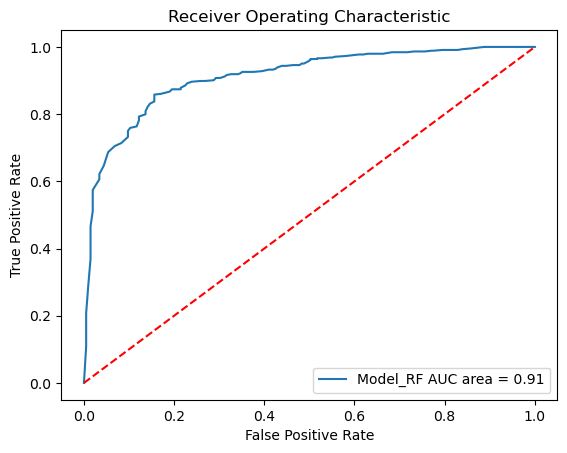

In [24]:
models = [{"label": "Model_RF", "model": model_RF}]
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [26]:
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Accuracy: 0.73
Sensitivity: 0.99
Specificity: 0.16
AUC: 0.88


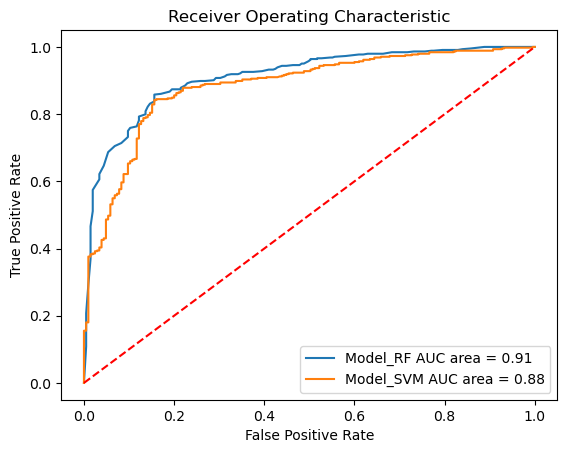

In [27]:
models.append({"label": "Model_SVM", "model": model_SVM})
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [28]:
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3))
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Accuracy: 0.81
Sensitivity: 0.93
Specificity: 0.54
AUC: 0.88


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


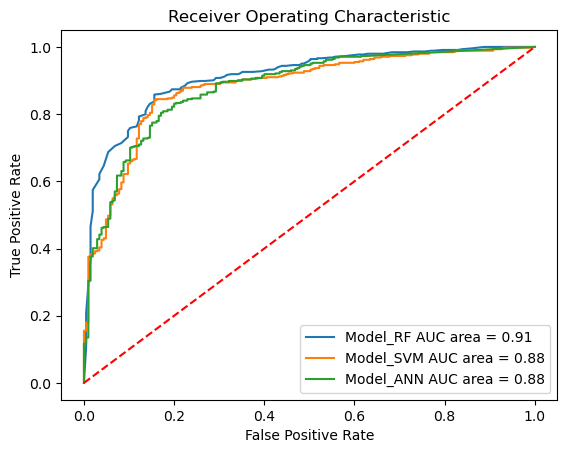

In [29]:
models.append({"label": "Model_ANN", "model": model_ANN})
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);